In [1]:

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [3]:

img = torchvision.io.read_image("dog.jpg")
img.shape

torch.Size([3, 1365, 2048])

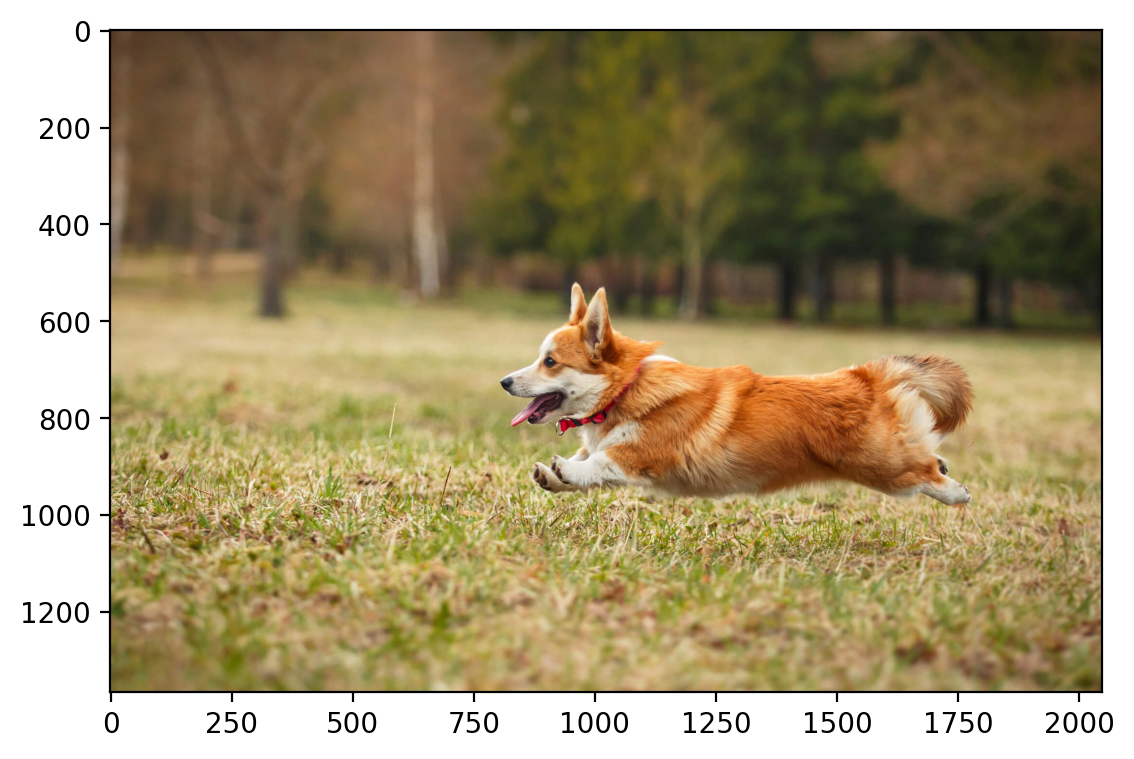

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [6]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)

torch.Size([3, 400, 400])


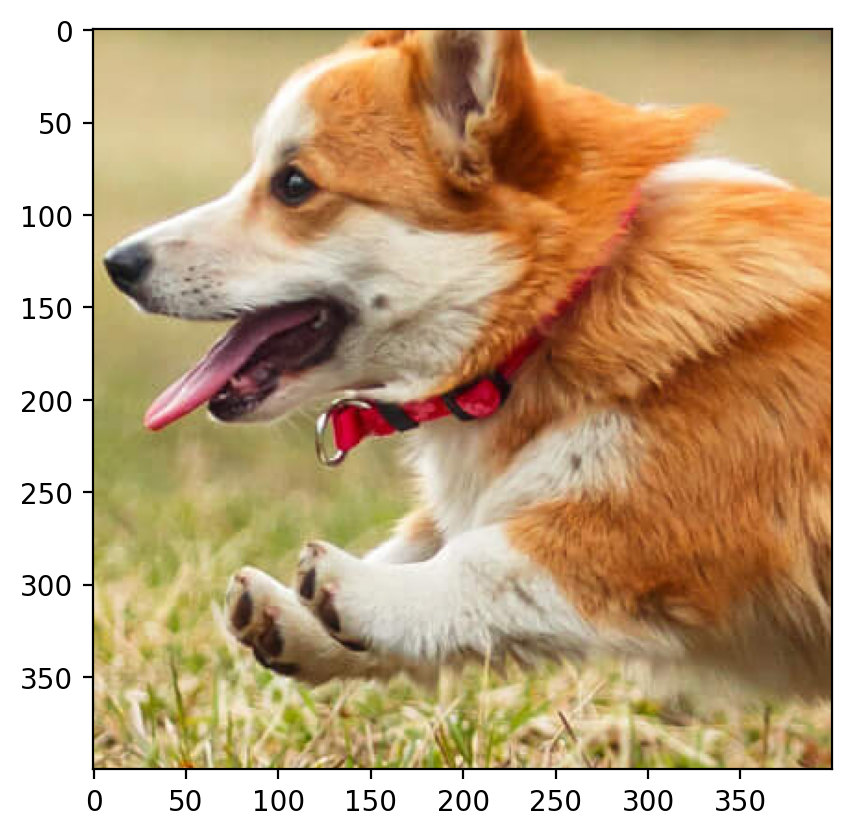

In [8]:

crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [9]:
crop = crop.to(device)


Resizing the image using OpenCv


torch.Size([200, 200, 3])


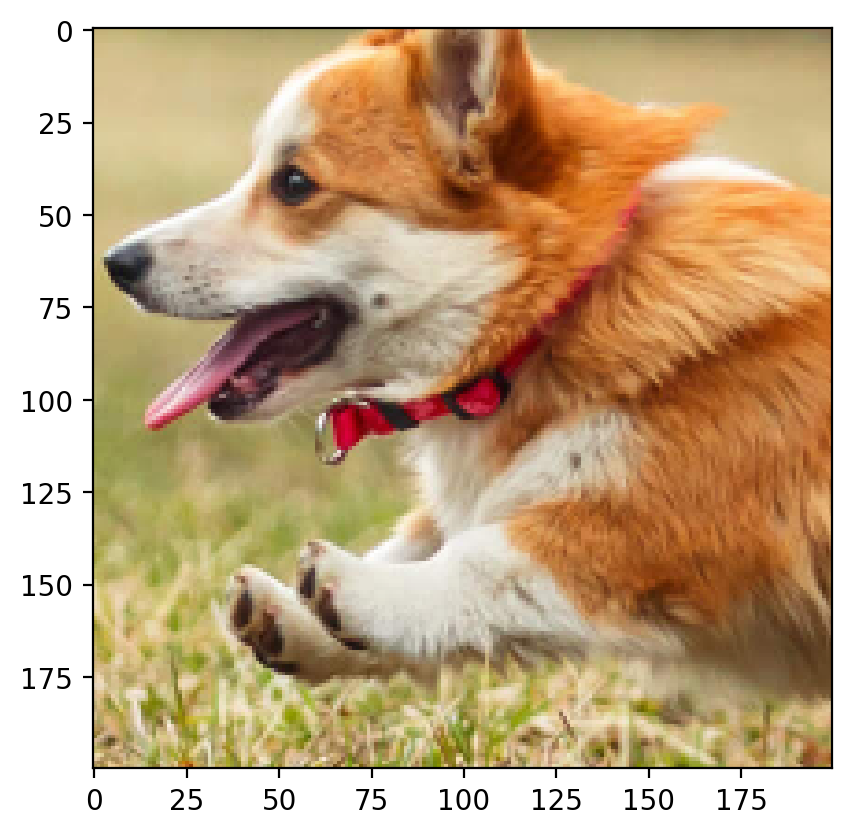

In [11]:
import cv2

resized_crop = cv2.resize(rearrange(crop, 'c h w -> h w c').cpu().numpy(), (200, 200))

resized_crop = torch.tensor(resized_crop)

resized_crop = resized_crop.to(device)
print(resized_crop.shape)
plt.imshow(resized_crop.cpu().numpy())


In [12]:

def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (height, width , num_channels)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    height, width , num_channels = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'h w c-> (h w) c').float()
    return X, Y

In [13]:
dog_X , dog_Y = create_coordinate_map(resized_crop)
print(dog_X.shape)
print(dog_Y.shape)
print(dog_X.device)
print(dog_Y.device)

torch.Size([40000, 2])
torch.Size([40000, 3])
cuda:0
cuda:0


In [14]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [15]:

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [16]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [17]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2) , random_state=42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

We already have two feature for our X_dog dataset which is made of corrodinates axis , now we are appending more feature to our X_dog dataset using RFFSampler which inheritly uses Random Forier Feature.

In [18]:
X_dog_rff = create_rff_features(dog_X_scaled, 15000, 0.008)

print(X_dog_rff.shape)
print(dog_Y.shape)
     

torch.Size([40000, 15000])
torch.Size([40000, 3])


In [19]:

model = LinearModel(X_dog_rff.shape[1], dog_Y.shape[1])

model.to(device)

train(model, 0.005, X_dog_rff, dog_Y, 2500)

Epoch 0 loss: 0.368384
Epoch 100 loss: 0.050254
Epoch 200 loss: 0.013503
Epoch 300 loss: 0.008615
Epoch 400 loss: 0.006422
Epoch 500 loss: 0.004992
Epoch 600 loss: 0.004000
Epoch 700 loss: 0.003285
Epoch 800 loss: 0.002754
Epoch 900 loss: 0.002349
Epoch 1000 loss: 0.002034
Epoch 1100 loss: 0.001786
Epoch 1200 loss: 0.001588
Epoch 1300 loss: 0.001429
Epoch 1400 loss: 0.001300
Epoch 1500 loss: 0.001194
Epoch 1600 loss: 0.001107
Epoch 1700 loss: 0.001034
Epoch 1800 loss: 0.000974
Epoch 1900 loss: 0.000922
Epoch 2000 loss: 0.000879
Epoch 2100 loss: 0.000842
Epoch 2200 loss: 0.000810
Epoch 2300 loss: 0.000783
Epoch 2400 loss: 0.000761


0.0007411771803162992

Now we have learn the Model for 200 x 200 image , Now we will create a feature corrdinates axis for 400 x 400 then rescale it to -1 to 1 then try to find Y of size 400 x 400 x 3.

In [20]:

def create_coordinate_map2(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    height, width , ch = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    # Y = rearrange(img, 'c h w -> (h w) c').float()
    return X

In [21]:
resized_crop.shape
dog_X_super  = create_coordinate_map2(resized_crop , scale=2)


In [22]:
super_scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X_super.cpu())

# Scale the X coordinates
dog_X_super_scaled = super_scaler_X.transform(dog_X_super.cpu())

# Move the scaled X coordinates to the GPU
dog_X_super_scaled = torch.tensor(dog_X_super_scaled).to(device)

# Set to dtype float32
dog_X_super_scaled = dog_X_super_scaled.float()
dog_X_super_scaled
     

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]], device='cuda:0')

Now We will add RFF in our dog_X_super_scaled which would be same as the number of feature that we have used earlier which is 15000 also we are taking the same random state as earlier so our features generated would correspond to previous features

In [23]:

def create_rff_features2(X, num_features, sigma, device):
    from sklearn.kernel_approximation import RBFSampler
    import numpy as np

    X_np = X.cpu().numpy()
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=42)
    X_rff = rff.fit_transform(X_np)
    X_tensor = torch.tensor(X_rff, dtype=torch.float32, device=device)

    return X_tensor

In [24]:
dog_X_super_scaled_rff = create_rff_features2(dog_X_super_scaled, 15000, 0.008 ,device)



In [25]:
print(dog_X_super_scaled_rff.device)
print(dog_X_super_scaled.device)
print(dog_X_super.device)
print(dog_X.device)
print(X_dog_rff.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [26]:
(dog_X_super_scaled_rff.element_size() * dog_X_super_scaled_rff.numel())/(1024 ** 3)


8.940696716308594

In [27]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original 400x400 Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


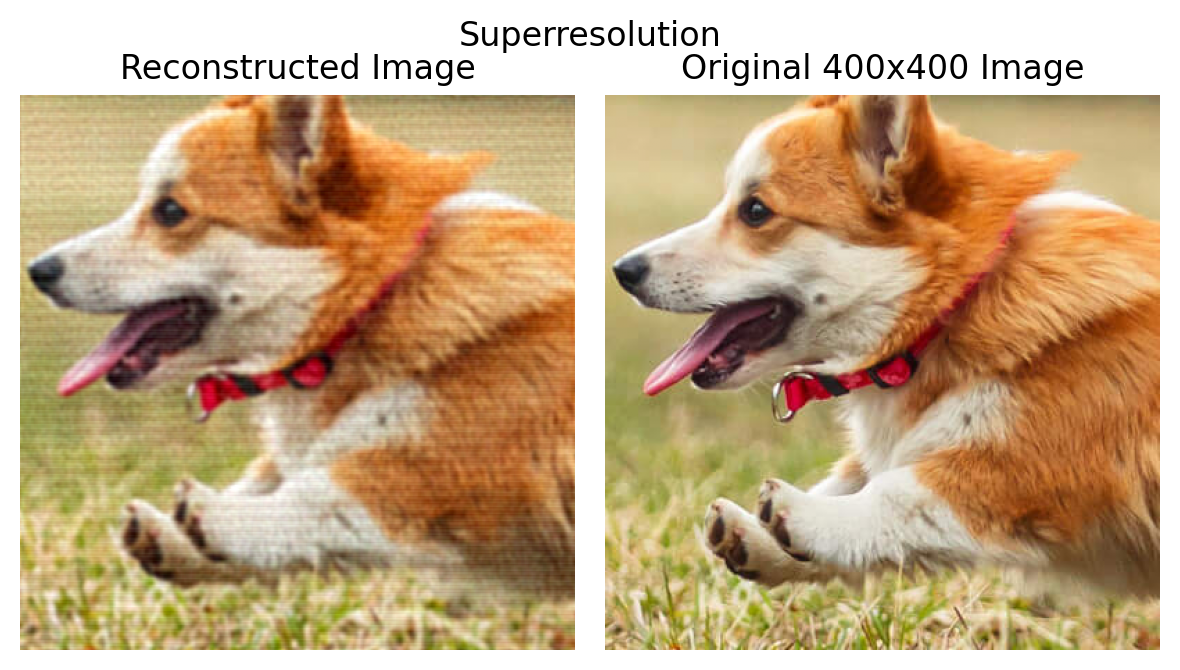

In [28]:
Output_Y = plot_reconstructed_and_original_image(crop, model , dog_X_super_scaled_rff , title="Superresolution")


In [29]:
mse = ((Output_Y.cpu().numpy() - rearrange(crop , 'c h w -> h w c').cpu().numpy())**2).sum() / (crop.shape[0]* crop.shape[1]* crop.shape[2])

rmse = np.sqrt(mse)
rmse

MAX=1.0 # MAX represents the maximum possible pixel value of the image (e.g., 255 for an 8-bit grayscale image or 1 for a normalized image).

PSNR = 10 * np.log10((MAX ** 2) / mse)

print('RMSE:', rmse)
print('Peak SNR:' , PSNR)

RMSE: 0.04185835584418937
Peak SNR: 27.564356686606615
